In [2]:
import gurobipy as gp
from gurobipy import GRB

import numpy as np
import graspy

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
sns.set()

In [6]:
def generate_latent_positions(n=50, d=2, acorn=None):
    """
    A function to generate an adjacency matrix.
    
    Input
    n - int
        If P is None then n is the number of latent positions to randomly generate.
    d - int
        If P is None the d is the dimension of the latent positions.
    acorn - int
        Random seed.
        
    Return
    X - np.array (shape=(n,d))
        An array of uniformly distributed points in the positive unit sphere
    """
    
    if acorn is not None:
        np.random.seed(acorn)
        
    mvns = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)

    mvns = abs(mvns) / np.linalg.norm(mvns, axis=1)[:, None]

    unis = np.random.uniform(size=n)**(1/d)
    X = mvns * unis[:, None]
                
    return X


def sample_moment(X, k=1):
    """
    Estimate the kth sample moment.
    
    Input
    X - np.array (length=n or shape=(n,d))
        i.i.d. realizations of a random variable.
    k - int (default=1)
        Moment to estimate.
    """
    if X.ndim == 1:
        estimate = np.mean(X**k)
    elif X.ndim == 2:
        n, d = X.shape
        if k == 1:
            estimate = np.mean(X, axis=0)
        elif k == 2:
            estimate = np.mean(np.array([X[i, np.newaxis].T @ X[i, np.newaxis] for i in range(n)]), axis=0)
            
    return estimate
        
    
def ASE_covariance(X, ind):
    x = X[ind]

    # this might break with ind = 0
    X_no_x = np.concatenate((X[:ind], X[ind+1:]))
    
    n, d = X_no_x.shape
    
    covs = np.array([X_no_x[i, np.newaxis].T @ X_no_x[i, np.newaxis] for i in range(n)])
    innards = np.array([x @ X_no_x[i] - x @ covs[i] @ x[:, np.newaxis] for i in range(n)])
    
    delta = np.mean(covs, axis=0)
    delta_inv = np.linalg.pinv(delta)
    
    scaled_covs = np.mean(np.array([covs[i] * innards[i] for i in range(n)]), axis=0)
        
    Sigma_x = delta_inv @ scaled_covs @ delta_inv
    
    return Sigma_x


def LSE_covariance(X, ind):
    x = X[ind]
    
    X_no_x = np.concatenate((X[:ind], X[ind+1:]))
    n, d = X_no_x.shape
    mu = np.mean(X_no_x, axis=0)
    
    denoms = np.array([X_no_x[i] @ mu for i in range(n)])
    
    # could do more succintly
    mu_t = np.mean(np.array([X_no_x[i] / denoms[i] for i in range(n)]), axis=0)
    
    
    covs = np.array([X_no_x[i, np.newaxis].T @ X_no_x[i, np.newaxis] for i in range(n)])
    delta_t = np.mean(np.array([covs[i] / denoms[i] for i in range(n)]), axis=0)
    
    delta_t_inv = np.linalg.pinv(delta_t)
    
    prod11 = np.array([(delta_t_inv @ X_no_x[i, np.newaxis].T) / denoms[i] for i in range(n)])
    prod12 = x[:, np.newaxis].T / (2*x@mu)
    prod = prod11 - prod12.T
    
    prod21 = np.array([(X_no_x[i, np.newaxis] @ delta_t_inv) / denoms[i] for i in range(n)])
    prod22 = x / (2*x@mu)
    prod2 = prod21 - prod22
    prod = prod @ prod2
    
#     print((x @ X_no_x[0]).shape)
#     print(x[:, np.newaxis].shape, covs[0].shape)
    prod3 = np.array([x @ X_no_x[i] - x[:, np.newaxis].T @ covs[i] @ x[:, np.newaxis] for i in range(n)])[0]
#     print(prod3)
    prod3 = prod3 / (x@mu)
    
    prod = prod * prod3[:, np.newaxis]
    
    Sigma_x = np.mean(np.array(prod), axis=0)
        
    return Sigma_x


def identity(X, ind):
    _, d = X.shape
    return np.eye(d)

def laplacian_means(X, T=None):
    n,d = X.shape
    
    if T is None:
        T = np.sqrt(np.diag(1/(X @ X.T @ np.ones(n))))
    
    return T @ X
  

def generate_distance_matrix(A, embedding_functions, covariance_functions, ind=0,acorn=None):
    """
    A function to generate a distance matrix given an adjacency matrix. The ith column of the
    distance matrix is the Euclidean distance from the first node in the graph to the other
    nodes in the ith embedding.
    
    Input
    A - np.array (shape=(n,n))
        Probability matrix or adjacency matrix.
    emebedding_functions - list of functions (length=J)
        Embedding methods for A.
    covariance_functions - list of np.arrays (length=J)
        Functions estimate the covariance used to calculate distances.
    ind - int
        Index of v star.
    acorn - int
        Random seed.
        
    Return
    dist_matrix - np.array (shape=(n, J))
        Distance matrix where the ith column is the Euclidean distance from v_star
        to all of the other nodes in the graph in the ith embedding.
    """
    
    if acorn is not None:
        np.random.seed(acorn)
        
    n = A.shape[0]
        
    J = len(covariance_functions)
            
    dist_matrix = np.zeros((n, J))
    
    for j, embed in enumerate(embedding_functions):
        temp_X = embed(A)
            
        if isinstance(covariance_functions[j], np.ndarray):
            temp_cov = covariance_functions[j]
        else:
            temp_cov = covariance_functions[j](temp_X, ind)
            
        diffs = np.array([temp_X[ind] - temp_X[i] for i in range(n)])
        dist_matrix[:, j] = np.sqrt(np.array([diffs[i].T @ temp_cov @ diffs[i] for i in range(n)]))
       
        if np.sum(dist_matrix[:, j] < 0) > 0:
            print("i broke on distance %i"%(j))
    return dist_matrix


def generate_S_indices(dist_matrix, alpha, n_inds=1, return_new_dists=False):
    """
    A function to generate the nodes of interest.
    
    Input
    dist_matrix - np.array (shape=(n,J))
        Array containing the distances between the vertex of interest and the other n - 1
        vertices. It is assumed that the vertex of interest is indexed by 0.
    alpha - float or array-like
        Coefficients of the distances to generate the ground truth. alpha can only be an int
        if J == 2. If alpha is array-like then the sum of alpha must be 1.
    n_inds - int or func
        Number of vertices in the vertex set of interest. If n_inds is a function then the
        ceiling of n_inds(n) is used.
        
    Return
    S - np.array (length=n_inds)
        A list of indices of length n_inds in range(1,n) corresponding to vertices of interest.
    """
    
    n, J = dist_matrix.shape
    
    if isinstance(alpha, float):
        if J == 2:
            alpha = [alpha, 1-alpha]
        elif J == 4:
            alpha = 0.5*np.array([alpha, 1-alpha, alpha, 1-alpha])
    
    assert np.sum(alpha) == 1
    
    if not isinstance(n_inds, int):
        n_inds = int(np.math.ceil(n_inds(n)))
    
    new_distances = np.average(dist_matrix, axis=1, weights=alpha)
    
    new_nearest_neighbors = np.argsort(new_distances)
    
    S = new_nearest_neighbors[1:n_inds+1]
    
    if return_new_dists:
        return S, new_distances
    else:
        return S


def optimal_distance(dist_matrix, S_indices, model_name=None, return_new_dists=True):
    """
    A function to find the weights of optimal linear combination of distances.
    
    Input
    dist_matrix - np.array (shape=(n, J))
        Array containing the distances between the vertex of interest and the other n - 1
        vertices. It is assumed that the vertex of interest is indexed by 0.
    S_indices - array-like
        Array-like containing the indices of the vertices that should be at the top of the
        nomination list for the vertex of interest.
        
    Return
    weights - np.array (length=J)
        Array containing the coefficients for the optimal distance function.
    """
    
    n, J = dist_matrix.shape
    M = np.sum(abs(dist_matrix))
    
    S = len(S_indices)
    Q_indices = np.array([i for i in range(1, n) if i not in S_indices])
    Q = len(Q_indices)
    
    M = np.sum(abs(dist_matrix))
    
    if model_name is not None:
        m = gp.Model(name='%s'%(model_name))
    else:
        m= gp.Model()
        
    m.setParam('OutputFlag', 0)

    ind = m.addVars(Q, vtype=GRB.BINARY, name='ind')
    m.setObjective(gp.quicksum(ind), GRB.MINIMIZE)

    w = m.addVars(J, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='w')
    m.addConstr(w.sum() == 1)

    # There's likely a more pythonic way to set up these constraints (in particular using m.addConstrs(..))
    for s in S_indices:
        temp_s = gp.tupledict([((i), dist_matrix[s, i]) for i in range(J)])
        for i, q in enumerate(Q_indices):
            temp_q = gp.tupledict([((i), dist_matrix[q, i]) for i in range(J)])
            m.addConstr(w.prod(temp_s) <= w.prod(temp_q) + ind[i]*M)
        
    m.optimize()
    
    alpha_hat = np.array([i.X for i in list(w.values())])
    
    if model_name:
        m.write('%s.ip'%(model_name))
        
    if return_new_dists:
        return alpha_hat, np.average(dist_matrix, axis=1, weights=alpha_hat)
    
    return alpha_hat


def rank_distance(true_ranks, estimated_ranks):
    return np.mean(abs(true_ranks - estimated_ranks))


def mean_reciprocal_rank(rank_list, inds):
    """
    Calculates mean reciprocal rank given a rank list and set of indices of interest.
    
    Input
    rank_list - array-like (length=n-1)
        A ranked array-like of objects (assumed to be integers).
    inds - array-like (length<=n-1)
        A array-like of objects (assumed to be integers).
        
    Return
    mrr - float
        Mean reciprocal rank of the objects in inds.
    """
        
    ranks = np.array([np.where(rank_list == i)[0][0] for i in inds]) + 1
    return np.mean(1/ranks)

def mean_rank(rank_list, inds):
    ranks = np.array([np.where(rank_list == i)[0][0] for i in inds]) + 1
#     print(ranks)
    return np.mean(ranks)


def monte_carlo(mc_its, P, emebdding_functions, covariance_functions, alpha, n_inds, s_stars, latent=True, poc=False, acorn=None):
    """
    Function to run a bunch of simulations.
    
    See documentation for above functions.
    
    Return
    mmrs - np.array (shape=(mc_its, J+1))
        Matrix of mean reciprocal ranks for each of the embedding functions and the estimated
        optimal distance.
    """
    if acorn is None:
        np.random.seed(acorn)
        
    J = len(embedding_functions)
        
    errors = np.zeros((mc_its, J+1))
    
    if J in [2, 4]:
        alpha_hats = np.zeros(mc_its)

    true_dist = generate_distance_matrix(P, embedding_functions=embedding_functions, 
                                         covariance_functions=covariance_functions)
    
    all_S_inds, new_dists = generate_S_indices(true_dist, alpha, n_inds=n_inds, return_new_dists=True)
    true_rankings = np.argsort(new_dists)
    
    if isinstance(s_stars, np.ndarray):
        for i,s in enumerate(s_stars):
            if s < 0:
                s_stars[i] = len(all_S_inds) + s
        S_star_inds = s_stars
    elif isinstance(s_stars, int):
        S_star_inds = np.random.choice(all_S_inds, size=s_stars)
    else:
        raise ValueError('bad')
    S_inds = np.array([i for i in all_S_inds if i not in S_star_inds])
        
        
    for i in range(mc_its):
        connected = False
        while not connected:
            A = graspy.simulations.rdpg(X)
            connected = graspy.utils.is_fully_connected(A)
            
        if poc:
            dist_matrix = true_dist
        else:              
            dist_matrix = generate_distance_matrix(A, embedding_functions, 
                                                   covariance_functions=covariance_functions)
        
        if not latent:
            all_S_inds = generate_S_indices(true_dist, alpha, n_inds=n_inds)
            if s_stars == 1:
                S_star_inds = np.array([len(all_S_inds) - 1])
            else:
                S_star_inds = np.random.choice(all_S_inds, size=s_stars)
            S_inds = np.array([i for i in all_S_inds if i not in S_star_inds])
            
        alpha_hat_vec, opt_dists = optimal_distance(dist_matrix, S_inds)
        
        if J in [2, 4]:
            alpha_hats[i] = alpha_hat_vec[0]
            
#         print(dist_matrix)
                        
        ranked_lists = [np.argsort(dist_matrix[:, j]) for j in range(J)]
        ranked_lists.append(np.argsort(opt_dists))

#         print("\n")
#         for R in ranked_lists:
#             print(R)
        errors[i] = np.array([rank_distance(S_star_inds, np.where(R == true_rankings[S_star_inds])) for R in ranked_lists])
        
    if J in [2, 4]:
        return alpha_hats, errors
    else:
        return errors


def identifiability_check(dist_matrix, alphas):
    
    n, J = dist_matrix.shape
    assert J == 2
    
    rank_lists = []
    
    for i, a in enumerate(alphas):
        new_dist = a*dist_matrix[:, 0] + (1-a)*dist_matrix[:, 1]
        rank_lists.append(list(np.argsort(new_dist)[1:]))
        
    unique_lists = []
    unique_ids = np.zeros(len(alphas))
    
    for i, a in enumerate(alphas):
        temp_list = rank_lists[i]
        unique = True
        for j, list_ in enumerate(unique_lists):
            if list_ == temp_list:
                unique_ids[i] = j+1
                unique = False
        if unique:
            unique_lists.append(temp_list)
            unique_ids[i] = len(unique_lists)
    return unique_ids

In [7]:
np.random.seed(11)

# Number of vertices, latent space dimension
n, d = 50, 2

# Latent positions
X = generate_latent_positions(n=n, d=d)

# Probability matrix
P = X @ X.T

mc_its=100
X0 = np.array([0.5, 0.5])[np.newaxis, :]
# X = np.concatenate((X0, X), axis=0)
embedding_functions = [graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform,
                        graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform]
covariance_functions = [identity, identity]
J = len(embedding_functions)
h=0.1
# alphas = np.arange(0,1+h,step=h)
alphas = np.arange(0, 1+h, step=h)
# alphas = [0.0, 0.5, 1.0]
n_inds = 6
s_stars = np.array([-1])
acorn=2

mmrs_by_alpha_true = np.zeros((len(alphas), mc_its, J+1))
alpha_hats_by_alpha_true = np.zeros((len(alphas), mc_its))

mmrs_by_alpha_poc = np.zeros((len(alphas), 2, J+1))
alpha_hats_by_alpha_poc = np.zeros((len(alphas), 2))

for i, alpha in enumerate(tqdm(alphas)):
    alpha_hats_by_alpha_true[i], mmrs_by_alpha_true[i] = monte_carlo(mc_its, P, embedding_functions,
                                                           covariance_functions,
                                                           alpha, n_inds, s_stars=s_stars, acorn=acorn, latent=True, poc=False)
    alpha_hats_by_alpha_poc[i], mmrs_by_alpha_poc[i] = monte_carlo(2, P, embedding_functions,
                                                           covariance_functions,
                                                           alpha, n_inds, s_stars=s_stars, acorn=acorn, latent=True, poc=True)

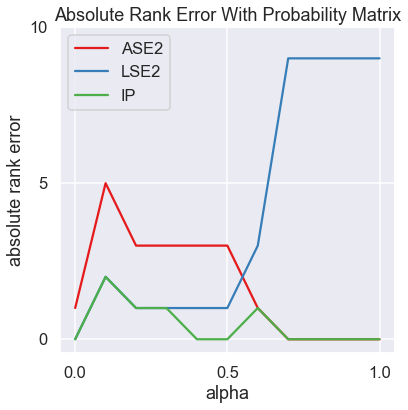

In [14]:
sns.set(context='talk')
labels = ['ASE2', 'LSE2', 'IP']

mean_mmrs = np.mean(mmrs_by_alpha_poc, axis=1)
std_err_mmrs = np.std(mmrs_by_alpha_poc, axis=1, ddof=1) / np.sqrt(mc_its)

fig, ax = plt.subplots(1,1, figsize=(6,6))
c = sns.color_palette('Set1', n_colors=J+3)
for i in range(len(labels)):
#     ax.plot(np.arange(len(alphas)), mean_mmrs[:, i], label = labels[i], c=c[i])
    ax.plot(alphas, mean_mmrs[:, i], label = labels[i], c=c[i])
    ax.fill_between(alphas, 
        mean_mmrs[:, i] + 1.96*std_err_mmrs[:, i], 
        mean_mmrs[:, i] - 1.96*std_err_mmrs[:, i], 
        where=mean_mmrs[:, i] + 1.96*std_err_mmrs[:, i] >= mean_mmrs[:, i] - 1.96*std_err_mmrs[:, i], 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)

truth = mean_rank(np.arange(n-1), [9]) #np.arange(np.math.ceil(n_inds(n)))
ax.set_xlabel('alpha')
ax.set_ylabel('absolute rank error')
ax.set_title('Absolute Rank Error With Probability Matrix')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 5, 10])
ax.legend()

plt.savefig('figures/optimal-distance-3/nmc%in%id%i_IP_alpha0to1by01_latent_poc.png'%(mc_its, n, d), dpi=500)

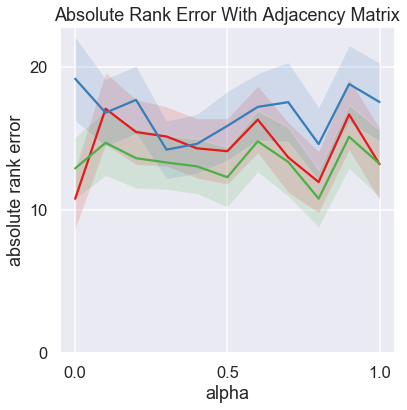

In [15]:
mean_mmrs = np.mean(mmrs_by_alpha_true, axis=1)
std_err_mmrs = np.std(mmrs_by_alpha_true, axis=1, ddof=1) / np.sqrt(mc_its)

fig, ax = plt.subplots(1,1, figsize=(6,6))
c = sns.color_palette('Set1', n_colors=len(labels))
for i in range(len(labels)):
#     ax.plot(np.arange(len(alphas)), mean_mmrs[:, i], label = labels[i], c=c[i])
    ax.plot(alphas, mean_mmrs[:, i], label = labels[i], c=c[i])
    ax.fill_between(alphas, 
        mean_mmrs[:, i] + 1.96*std_err_mmrs[:, i], 
        mean_mmrs[:, i] - 1.96*std_err_mmrs[:, i], 
        where=mean_mmrs[:, i] + 1.96*std_err_mmrs[:, i] >= mean_mmrs[:, i] - 1.96*std_err_mmrs[:, i], 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)

truth = mean_rank(np.arange(n-1), [9]) #np.arange(np.math.ceil(n_inds(n)))
ax.set_xlabel('alpha')
ax.set_ylabel('absolute rank error')
ax.set_title('Absolute Rank Error With Adjacency Matrix')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0,10,20])
# ax.legend()

plt.savefig('figures/optimal-distance-3/nmc%in%id%i_IP_alpha0to1by01_latent.png'%(mc_its, n, d), dpi=500)

Our goal, given a vertex of interest $ v^{*} := 0 $, a set of vertices $ S \subseteq \{1, .., n\} =: [n] $, and a distance matrix 

\begin{align}
\Delta = \begin{bmatrix} 
d^{1}(x_{0}, x_{1}) & .. & d^{J}(x_{0}, x_{1}) \\
\vdots & \ddots & \vdots \\
d^{1}(x_{0}, x_{n}) & .. & d^{J}(x_{0}, x_{n})
\end{bmatrix}
\end{align}

is to construct a distance $ d^{*} = \sum \alpha_{j} d^{j} $ with $ \sum \alpha_{j} = 1 $ such that $ d^{*}(x_{0}, x_{s^{*}}) $ is "small" for a second, unknown vertex of interest $ s^{*} \notin S \cup \{0\} $. 

Assuming that $ x_{s^{*}} $ is "similar" to the $ x_{s} $ corresponding to the elements of $ S $, to find $ d^{*} $ we propose the following Integer Program (implemented using Gurobi):

..



Now suppose $ X_{0}, .., X_{n} iid \sim F $ where $ F $ is such that for $ X, Y \in \mathbb{R}^{d} iid \sim F $ $ 0 \le \langle X, Y \rangle \le 1 $. Suppose there exist $ J $ transformations $ T^{j}: \mathbb{R}^{d} \to \mathbb{R}^{d_{j}} $ and $ J $ distance functions $ d^{1}, .., d^{J}$ where $ d^{j}: \mathbb{R}^{d_{j}} \times \mathbb{R}^{d_{j}} \to [0, \infty) $

Let $ X $ denote the matrix with $ X_{0}, .., X_{n} $ as its rows. That is,
\begin{align*}
X = \begin{bmatrix} X_{0}^{T} \\ \vdots \\ X_{n}^{T} \end{bmatrix}
\end{align*}

Further, let $ P = X X^{T} = U \Sigma U^{T} $ and $ A $ be such that $ A_{ij} \sim Bernoulli(P_{ij}) $, with all $ A_{ij} $ independent and $ A_{ii} = 0 $.

We are given $ A $, a vertex of interest $ v^{*} := 0 $, a set of vertices $ S \subseteq [n] $, $ J $ transformations and $ J $ corresponding distance functions. As above, our goal is to construct a distance $ d^{*} = \sum \alpha_{j} d^{j} $ with $ \sum \alpha_{j} = 1 $ such that $ d^{*}(x_{0}, x_{s^{*}}) $ is "small" for a second, unknown vertex of interest $ s^{*} \notin S \cup \{0\} $.

We do not observe $ x_{0}, .., x_{n} $ directly. Instead, we observe $ A = \hat{U} \hat{\Sigma} \hat{U}^{T} $. The ith row of $ \hat{X} = \hat{U} \hat{|\Sigma|}^{1/2} $ is consistent for the ith row of $ X $. We then construct a noisy version of the distance matrix $ \Delta $ described above:
\begin{align*}
\hat{\Delta} = 
\begin{bmatrix} d^{1}(T^{1}(\hat{X}_{0}), T^{1}(\hat{X}_{1}) & .. & d^{J}(T^{J}(\hat{X}_{0}), T^{J}(\hat{X}_{1}) \\
\vdots & \ddots & \vdots \\
d^{1}(T^{1}(\hat{X}_{0}), T^{1}(\hat{X}_{n}) & .. & d^{J}(T^{J}(\hat{X}_{0}), T^{J}(\hat{X}_{n})
\end{bmatrix}
\end{align*} and use $ \hat{\Delta} $ as input to our proposed Integer Program. 

In the simulations below, we let $ X_{0} = x_{0}, .., X_{n} = x_{n} $ be realizations from the uniform distribution on the positive unit disk in $ \mathbb{R}^{2} $. We consider the two transformations $ T^{1}(x_{i}) = x_{i} $ and $ T^{2}(x_{i}) = \frac{x_{i}}{\sum x_{i}^{T} x_{j}} $ with the corresponding distances taken to be Euclidean.

For a fixed $ \alpha \in [0, 1] $ we define $ d_{\alpha}(x_{i}, x_{j}) = \alpha d(T^{1}(x_{i}), T^{1}(x_{j})) + (1-\alpha)d(T^{2}(x_{i}), T^{2}(x_{j})) $. We let $ S_{\alpha} $ be the set of $ m $ points closest to $ x_{0} $ as defined by $ d_{\alpha} $ and $ s^{*} $ to be the $ (m + 1) $th closest point to $ x_{0} $ as defined by $ d_{\alpha} $.